# LIM forecasting: Satellite data

Katie Brennan  
started May 2021  
  
#### Goals: 
* Build LIM trained on satellite data to predict future months

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [4]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [7]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [8]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 60
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = int(25*12)
nvalid = int(38*12)
nyearsvalid = 38-25
nvalidtimes = 1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
limvars = ['sic']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
train_dsource = 'satellite'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'satellite'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

In [9]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()

## Build L from scratch: 

In [12]:
### Load cellarea file for satellite data: 
areacello = xr.open_dataset(fdic_train['fpath']+fdic_train['areacello'])

areacell = {}
areacell['areacello'] = areacello['areacello'].values

areacell_dict = {}
areacello_d = {}
areacello_d['lat'] = areacello.lat.values
areacello_d['lon'] = areacello.lon.values
areacello_d['units'] = 'km2'
areacello_d['ndof'] = 448*304

areacell_dict['areacello'] = areacello_d

### Load and truncate training data: 

In [14]:
wt=True
dt = False
var_dict = {}
var = 'sic'
var_ln = 'goddard_merged_seaice_conc_monthly'
    
X_var, var_dict = limkb.load_sat_data(var, var_ln,var_dict, fdic_train, 
                                      remove_climo=True, detrend=dt, verbose=True)

#X_var_filled = np.where((var_dict['sic']['lat']>82),1.0,X_var)

if dt is False: 
    x_var = np.reshape(X_var,(X_var.shape[0],X_var.shape[1]*X_var.shape[2])).T
else: 
    x_var = X_var

ntime = x_var.shape[1]
X_var_train = x_var[:,0:ntrain]
X_var_valid = x_var[:,ntrain:nvalid]

acell = areacell['areacello']
if len(acell.shape)>1:
    acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
else: 
    acell_1d = acell

[Ptrunc, E3, tot_var,
 tot_var_eig, W_all, 
 standard_factor] = limkb.step1_compress_individual_var(X_var_train, var, ntrunc, nmodes_sic, 
                                                              var_dict, areawt=acell_1d,
                                                              wt=wt, sic_separate=True)

Loading sic
removing climotology...
-----------------------------------------------------
completed in 1.9396724700927734 seconds
-----------------------------------------------------
truncating to 60
fraction in first 60 sic EOFs = 84.18024134482974


In [15]:
X_var_valid.shape, X_var_train.shape, 

((136192, 156), (136192, 300))

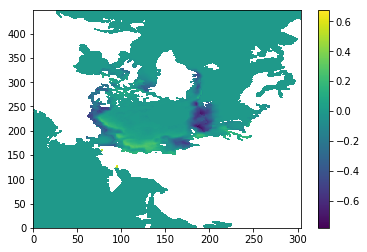

In [16]:
t=417
if dt is True: 
    plt.pcolormesh(np.reshape(X_var[:,t],(448,304)))
else: 
    plt.pcolormesh(X_var[t,:,:])
plt.colorbar()

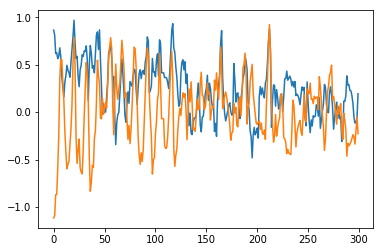

In [17]:
plt.plot(Ptrunc[0,:])
plt.plot(Ptrunc[1,:])
# plt.plot(Ptrunc[2,:])
# plt.plot(Ptrunc[3,:])

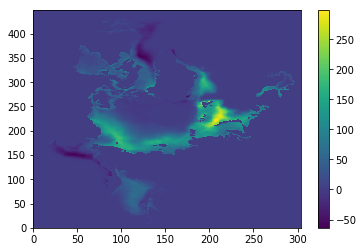

In [18]:
plt.pcolormesh(np.reshape(E3[:,0],(448, 304)))
plt.colorbar()

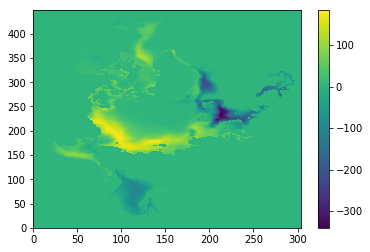

In [63]:
plt.pcolormesh(np.reshape(E3[:,1],(448, 304)))
plt.colorbar()

In [20]:
ndof_all = E3.shape[0]
P_train = Ptrunc

# [Ptrunc_all, E3_all, 
# Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                               var_dict, sic_separate=sic_separate)

# P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)


# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all, nmodes, E3_all, Ptrunc_sic, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

# [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                                  var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

In [21]:
P_train.shape

(60, 300)

## Train LIM: 

In [22]:
mo

'all'

In [23]:
# nmo = int(P_train.shape[1]/12)
# P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train[:,:-1], P_train[:,1:])
#    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [24]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

#### Any positive eigenvalues in L?

In [25]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

### Load and project validation data (when different than training data): 

In [26]:
# # Start with truncated training data: 
# mod_folder = 'truncated_model_data/historical/'
# mod_filename = '_ntrunc30_mpi_hist_kb_20210503.pkl'
# mod_sic_filename = '_ntrunc50_mpi_hist_kb_20210504.pkl'

# [Ptrunc_valid, Ptrunc_valid2, E3_valid, tot_var_valid, 
#  tot_var_eig_valid, W_all_valid, standard_factor_valid, 
#  nyears_train_valid, var_dict_valid] = limbuild.load_training_data_truncated(limvars, mod_folder, 
#                                                                              mod_sic_filename, 
#                                                                              mod_filename, mo, ntrain_valid)

# var_dict_valid = limbuild.get_var_incices(limvars, var_dict_valid)

In [27]:
def step1_projection_validation_var(X_train, E3, standard_factor, W): 
    """
    """
    if len(W.shape)<2:
        W_new = W[:,np.newaxis]
    else: 
        W_new = W
    eofs_out = E3/standard_factor
    # projection
    P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X_train))

    Ptrunc = P_var/standard_factor
        
    return Ptrunc

In [28]:
Ptrunc_valid = limkb.step1_projection_validation_var(X_var_valid, E3, standard_factor,W_all)

ndof_valid = E3.shape[0]
P_train_valid = Ptrunc_valid

In [29]:
Insamp

False

## Run Forecast: 

In [30]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3,4,5,6,7,8]
#lags = [0,1,2]
ntims = len(lags)
adj = True

if mo == 'all':
    if Insamp==True: 
        print('Performing in sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train,lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,0:nvalidtimes],lags,adjust=adj)
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
else: 
    if Insamp==True: 
        print('Performing in sample forecast')
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_2d[:,:,0],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
    
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

Performing out of sample forecast
Adjust is True...
NO negative eigenvalue found...
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8


In [31]:
LIM_fcast['x_forecast'].shape,P_train_valid.shape

((9, 60, 156), (60, 156))

## Decompress forecast and validate:

In [32]:
x_forecast_dcomp = np.zeros((len(lags),E3.shape[0],LIM_fcast['x_forecast'].shape[2]))
nmodes = E3.shape[1]
Weights = wt

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_decomp = np.matmul(E3,LIM_fcast['x_forecast'][i,:,:])
    
    if Weights is True: 
        X_dcomp = x_decomp/W_all[:,np.newaxis]
    else: 
        X_dcomp = x_decomp
    
    x_forecast_dcomp[i,:,:] = X_dcomp

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8


### All months: break up my month

In [33]:
x_forecast_dcomp_mo = np.reshape(x_forecast_dcomp, (x_forecast_dcomp.shape[0], x_forecast_dcomp.shape[1], 
                                                    int(x_forecast_dcomp.shape[2]/12),12))

x_forecast_dcomp_mo.shape

(9, 136192, 13, 12)

Month 0
Trained using month all...
Validating against month 0, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


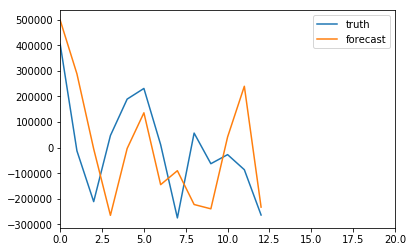

Month 1
Trained using month all...
Validating against month 1, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


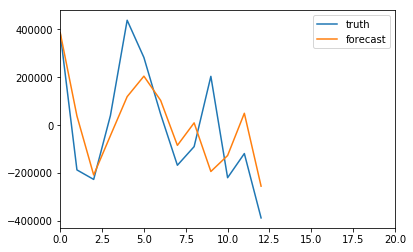

Month 2
Trained using month all...
Validating against month 2, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


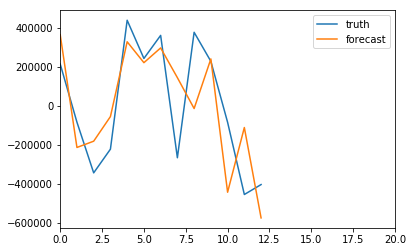

Month 3
Trained using month all...
Validating against month 3, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


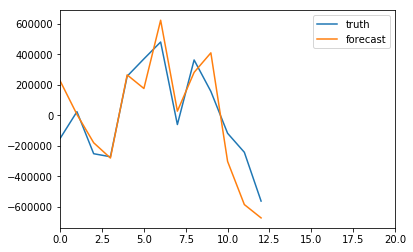

Month 4
Trained using month all...
Validating against month 4, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


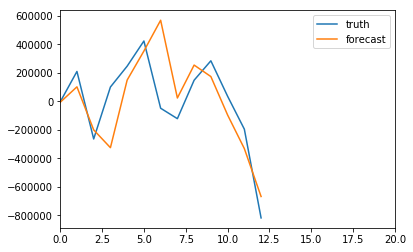

Month 5
Trained using month all...
Validating against month 5, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


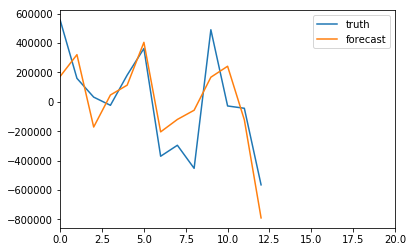

Month 6
Trained using month all...
Validating against month 6, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


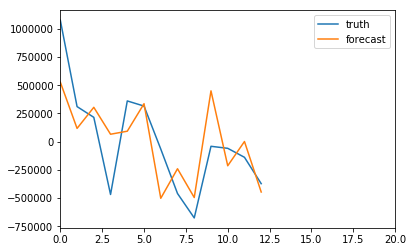

Month 7
Trained using month all...
Validating against month 7, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


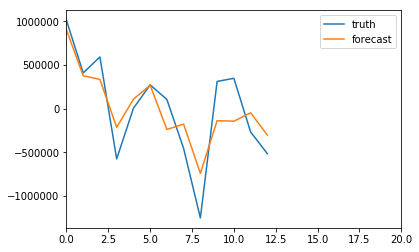

Month 8
Trained using month all...
Validating against month 8, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


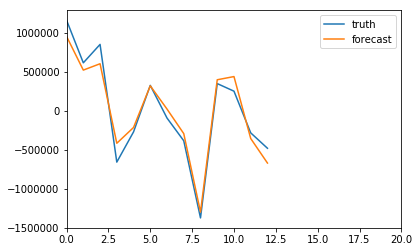

Month 9
Trained using month all...
Validating against month 9, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


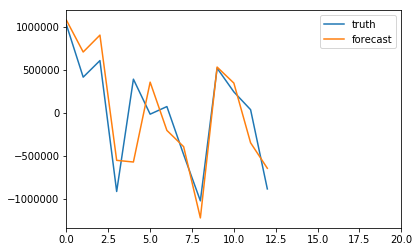

Month 10
Trained using month all...
Validating against month 10, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


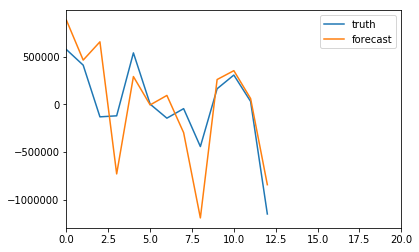

Month 11
Trained using month all...
Validating against month 0, year 1
Truth_anom shape: (136192, 12)
Forecast_anom shape: (136192, 12)


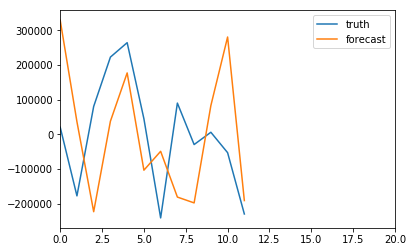

In [34]:
var = 'sic'
iplot=True
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10,11]
lag=1
validation_stats = {}

valid_stats = {}
v = {}

corr_tot = np.zeros((len(months)))
ce_tot = np.zeros((len(months)))
gm_var_ratio = np.zeros((len(months)))

for i,m in enumerate(months):
    print('Month '+str(m))
    print('Trained using month '+str(mo)+'...')
    nyears_train = int((X_var_train.shape[1]/12))
    nyears_valid = int((X_var_valid.shape[1]/12))
    
    X_train = np.reshape(X_var_train, (var_dict['sic']['var_ndof'],nyears_train,12))
    X_valid = np.reshape(X_var_valid, (var_dict['sic']['var_ndof'],nyears_valid,12))
    
    step = m
    if step>=11:
        step = step-11
        start_yr = 0+1
    else: 
        start_yr = 0
    print('Validating against month '+str(step)+', year '+str(start_yr))
    
    if Insamp==True: 
        x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
        x_truth = X_train[:,start_yr:,step]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
    else: 
        if lag == 0: 
            x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
            forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
            x_truth = X_valid[:,start_yr:,step]
            truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
        else: 
            x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
            forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
            x_truth = X_valid[:,start_yr:,step]
            truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

    
    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))
    
    
    tot_var_forecast = statskb.calc_tot_si(forecast_anom, areacell[areawt_name[var]], 
                                           areacell_dict['areacello']['units'], 
                                           var_dict[var]['lat'], lat_cutoff=0.0)
    tot_var_truth = statskb.calc_tot_si(truth_anom, areacell[areawt_name[var]], 
                                        areacell_dict['areacello']['units'], 
                                        var_dict[var]['lat'],lat_cutoff=0.0)
    
    if iplot==True: 
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
       # plt.ylim(-1.5,1.5)
        plt.legend()
        plt.show()
        
    corr_tot[i] = np.corrcoef(tot_var_truth,tot_var_forecast)[0,1]
    ce_tot[i] = LMR_utils.coefficient_efficiency(tot_var_truth,tot_var_forecast)
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom-forecast_anom)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio[i]=gm_error_var/gm_truth_var

valid_stats['corr_tot'] = corr_tot
valid_stats['ce_tot'] = ce_tot
valid_stats['gm_var_ratio'] = gm_var_ratio

validation_stats[var] = valid_stats

In [35]:
var='sic'
print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

sic: 0.5515446774534489


In [36]:
for i,var in enumerate(['sic']):
    print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

sic: 0.5515446774534489


In [37]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [38]:
validation_stats[var]['corr_tot']

array([0.50801008, 0.70858051, 0.69688712, 0.86864306, 0.72005132,
       0.75018628, 0.71607607, 0.86781205, 0.977466  , 0.84465068,
       0.75237404, 0.19006794])

In [39]:
corr_plot = np.zeros((12))
corr_plot[0] = validation_stats[var]['corr_tot'][-1]
corr_plot[1:] = validation_stats[var]['corr_tot'][:-1]

ce_plot = np.zeros((12))
ce_plot[0] = validation_stats[var]['ce_tot'][-1]
ce_plot[1:] = validation_stats[var]['ce_tot'][:-1]

ratio_plot = np.zeros((12))
ratio_plot[0] = validation_stats[var]['gm_var_ratio'][-1]
ratio_plot[1:] = validation_stats[var]['gm_var_ratio'][:-1]

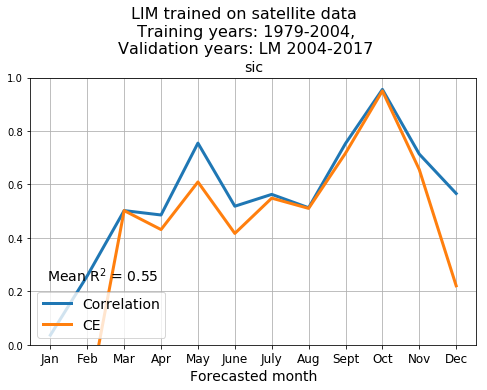

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(limvars):
    ax.plot(corr_plot**2, label='Correlation',linewidth=3.0)
    ax.plot(ce_plot,label='CE',linewidth=3.0)

    ax.set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax.set_xticks(np.arange(0,12,1))
    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=14)
    ax.text(-0.1,0.24, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle((' Training years: 1979-2017'+
                 ', Validation years: Same'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \nValidation years: LM '+str(int(1979+ntrain/12))+'-'+str(int(1979+nvalid/12))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax.legend(loc='lower left', fontsize=14)
# ax[2].set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.8)

In [41]:
for i,var in enumerate(limvars):
    print(var +': ' + str(np.mean(validation_stats[var]['gm_var_ratio'])))

sic: 0.847051547537142


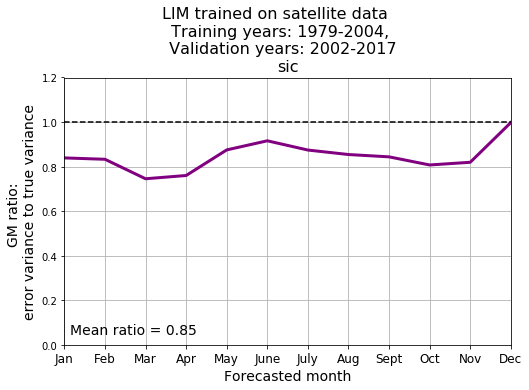

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(['sic']):
    ax.plot(ratio_plot,linewidth=3.0, color='purple')

#    ax[i].set_ylim(0,1)
    ax.set_xlim(0,10)
    ax.set_ylim(0,1.2)
    ax.set_xticks(np.arange(0,12,1))
    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=16)
    ax.text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax.axhline(1.0,color='k',linestyle='--')
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('Satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                 ', Validation years: Same'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on satellite data  \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \n Validation years: 2002-'+str(int(1979+nvalid/12))), fontsize=16)
    
# ax.set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Forecasted month', fontsize=14)
ax.set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.8)

## AR1 forecast for comparison: 

In [62]:
X_var_train.shape, X_var_valid.shape

((136192, 300), (136192, 156))

In [43]:
forecast, ar1_factor = statskb.red_noise_forecast_ar1(X_var_train.T, X_var_valid.T, lead=1)

In [44]:
forecast_hold_ar1 =  np.zeros((forecast.shape[1],nyearsvalid*12))
forecast_hold_ar1[:,1:] = forecast.T
forecast_ar1 = np.reshape(forecast_hold_ar1, (forecast.shape[1],nyearsvalid,12))
                                                    

valid_ar1 = np.reshape(X_var_valid,(X_var_valid.shape[0],nyearsvalid,12))


In [45]:
ar1_factor.shape, LIM_fcast[1]['Gt'].shape

((136192,), (60, 60))

Month 0
Validating against month 0, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


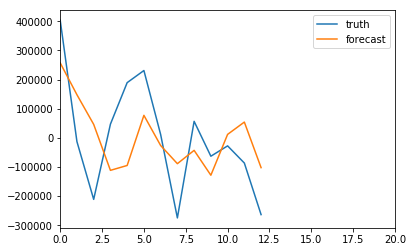

Month 1
Validating against month 1, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


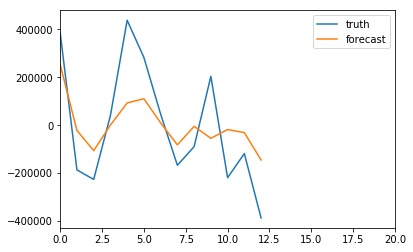

Month 2
Validating against month 2, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


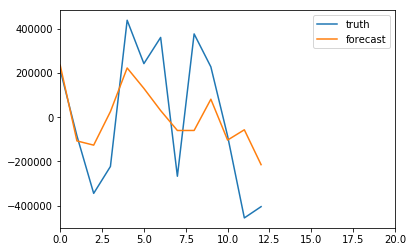

Month 3
Validating against month 3, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


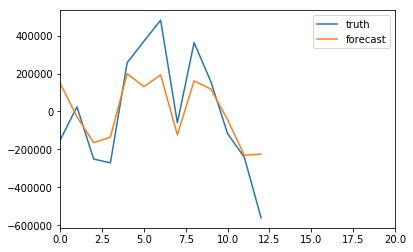

Month 4
Validating against month 4, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


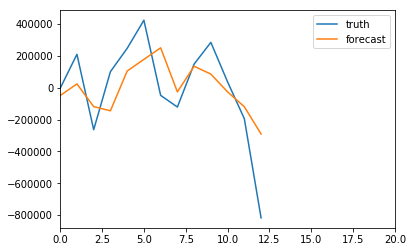

Month 5
Validating against month 5, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


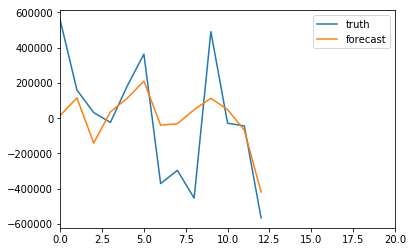

Month 6
Validating against month 6, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


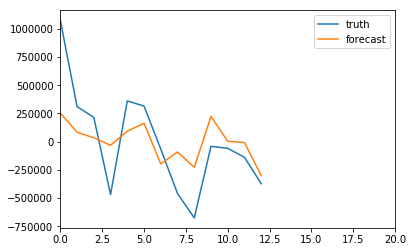

Month 7
Validating against month 7, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


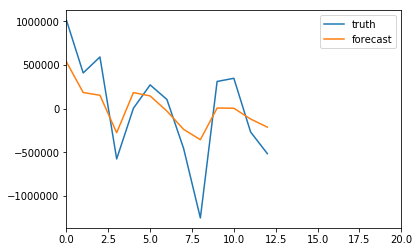

Month 8
Validating against month 8, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


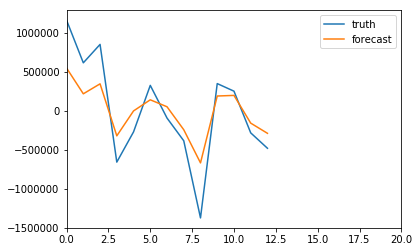

Month 9
Validating against month 9, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


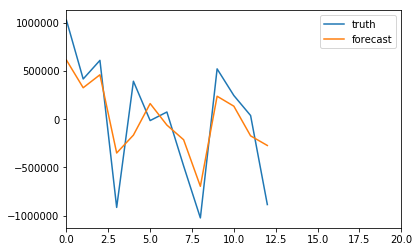

Month 10
Validating against month 10, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)


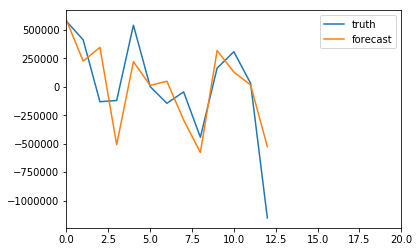

Month 11
Validating against month 0, year 1
Truth_anom shape: (136192, 12)
Forecast_anom shape: (136192, 12)


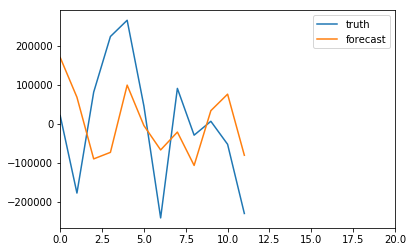

In [46]:
var = 'sic'
iplot=True
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10,11]
lag=1
validation_stats_ar1 = {}

valid_stats_ar1 = {}
v_ar1 = {}

corr_ar1 = np.zeros((len(months)))
ce_ar1 = np.zeros((len(months)))
gm_var_ratio_ar1 = np.zeros((len(months)))

for i,m in enumerate(months):
    print('Month '+str(m))
    forecast_hold_ar1 =  np.zeros((forecast.shape[1],nyearsvalid*12))
    forecast_hold_ar1[:,1:] = forecast.T
                                                    
    valid_ar1 = np.reshape(X_var_valid,(X_var_valid.shape[0],nyearsvalid,12))[:,:,m]
    
    step = m
    if step>=11:
        step = step-11
        start_yr = 0+1
    else: 
        start_yr = 0
    print('Validating against month '+str(step)+', year '+str(start_yr))
    
    forecast_ar1 = np.reshape(forecast_hold_ar1, (forecast.shape[1],nyearsvalid,12))[:,start_yr:,step]
    forecast_anom_ar1 = forecast_ar1 - np.nanmean(forecast_ar1,axis=1)[:,np.newaxis]

    valid_ar1 = np.reshape(X_var_valid,(X_var_valid.shape[0],nyearsvalid,12))[:,start_yr:,step]
    truth_anom_ar1 = valid_ar1 - np.nanmean(valid_ar1,axis=1)[:,np.newaxis]

    print('Truth_anom shape: '+str(truth_anom_ar1.shape))
    print('Forecast_anom shape: '+str(forecast_anom_ar1.shape))
     
    tot_var_forecast = statskb.calc_tot_si(forecast_anom_ar1, areacell[areawt_name[var]], 
                                           areacell_dict['areacello']['units'], 
                                           var_dict[var]['lat'], lat_cutoff=0.0)
    tot_var_truth = statskb.calc_tot_si(truth_anom_ar1, areacell[areawt_name[var]], 
                                        areacell_dict['areacello']['units'], 
                                        var_dict[var]['lat'],lat_cutoff=0.0)
    
    if iplot==True: 
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
       # plt.ylim(-1.5,1.5)
        plt.legend()
        plt.show()
        
    corr_ar1[i] = np.corrcoef(tot_var_truth,tot_var_forecast)[0,1]
    ce_ar1[i] = LMR_utils.coefficient_efficiency(tot_var_truth,tot_var_forecast)
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom_ar1-forecast_anom_ar1)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom_ar1 - np.nanmean(truth_anom_ar1,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio_ar1[i]=gm_error_var/gm_truth_var

valid_stats_ar1['corr_tot'] = corr_ar1
valid_stats_ar1['ce_tot'] = ce_ar1
valid_stats_ar1['gm_var_ratio'] = gm_var_ratio_ar1

validation_stats_ar1[var] = valid_stats_ar1

In [47]:
corr_plot_ar1 = np.zeros((12))
corr_plot_ar1[0] = validation_stats_ar1[var]['corr_tot'][-1]
corr_plot_ar1[1:] = validation_stats_ar1[var]['corr_tot'][:-1]

ce_plot_ar1 = np.zeros((12))
ce_plot_ar1[0] = validation_stats_ar1[var]['ce_tot'][-1]
ce_plot_ar1[1:] = validation_stats_ar1[var]['ce_tot'][:-1]

ratio_plot_ar1 = np.zeros((12))
ratio_plot_ar1[0] = validation_stats_ar1[var]['gm_var_ratio'][-1]
ratio_plot_ar1[1:] = validation_stats_ar1[var]['gm_var_ratio'][:-1]

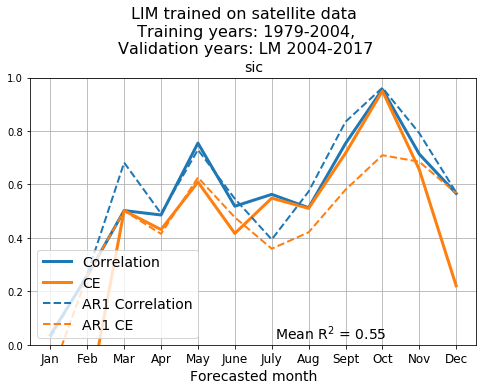

In [48]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(limvars):
    ax.plot(corr_plot**2, label='Correlation',linewidth=3.0)
    ax.plot(ce_plot,label='CE',linewidth=3.0)
    
    ax.plot(corr_plot_ar1**2, label='AR1 Correlation',linewidth=2.0, linestyle='--', color='tab:blue')
    ax.plot(ce_plot_ar1,label='AR1 CE',linewidth=2.0, linestyle='--', color='tab:orange')

    ax.set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax.set_xticks(np.arange(0,12,1))
    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=14)
    ax.text(6.1,0.02, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle((' Training years: 1979-2017'+
                 ', Validation years: Same'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \nValidation years: LM '+str(int(1979+ntrain/12))+'-'+str(int(1979+nvalid/12))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax.legend(loc='lower left', fontsize=14)
# ax[2].set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.8)

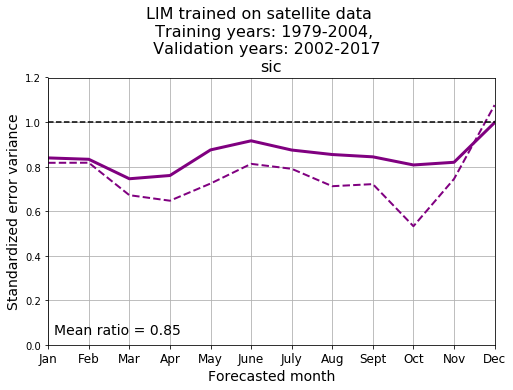

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(['sic']):
    ax.plot(ratio_plot,linewidth=3.0, color='purple')
    
    ax.plot(ratio_plot_ar1,linewidth=2.0, linestyle='--', color='purple')

#    ax[i].set_ylim(0,1)
    ax.set_xlim(0,10)
    ax.set_ylim(0,1.2)
    ax.set_xticks(np.arange(0,12,1))
    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=16)
    ax.text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax.axhline(1.0,color='k',linestyle='--')
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('Satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                 ', Validation years: Same'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on satellite data  \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \n Validation years: 2002-'+str(int(1979+nvalid/12))), fontsize=16)
    
# ax.set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Forecasted month', fontsize=14)
ax.set_ylabel('Standardized error variance', fontsize=14)

plt.subplots_adjust(top=0.8)

In [56]:
156/12

13.0

## Validation by grid cell: 

In [50]:
ndof = areacello_d['ndof']
ndof

136192

In [58]:
var = 'sic'
iplot=True
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10,11]
lag=1
validation_stats_ar1 = {}

valid_stats_ar1 = {}
v_ar1 = {}

corr_ar1 = np.zeros((ndof))
ce_ar1 = np.zeros((ndof))
gm_var_ratio_ar1 = np.zeros((ndof))

for i,m in enumerate(months):
    print('Month '+str(m))
    forecast_hold_ar1 =  np.zeros((forecast.shape[1],156))
    forecast_hold_ar1[:,1:] = forecast.T
                                                    
    valid_ar1 = np.reshape(X_var_valid,(X_var_valid.shape[0],13,12))[:,:,m]
    
    step = m
    if step>=11:
        step = step-11
        start_yr = 0+1
    else: 
        start_yr = 0
    print('Validating against month '+str(step)+', year '+str(start_yr))
    
    forecast_ar1 = np.reshape(forecast_hold_ar1, (forecast.shape[1],13,12))[:,start_yr:,step]
    forecast_anom_ar1 = forecast_ar1 - np.nanmean(forecast_ar1,axis=1)[:,np.newaxis]

    valid_ar1 = np.reshape(X_var_valid,(X_var_valid.shape[0],13,12))[:,start_yr:,step]
    truth_anom_ar1 = valid_ar1 - np.nanmean(valid_ar1,axis=1)[:,np.newaxis]

    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))
        
    for i in range(ndof): 
        corr_ar1[i] = np.corrcoef(truth_anom_ar1[i,:],forecast_anom_ar1[i,:])[0,1]
        ce_ar1[i] = LMR_utils.coefficient_efficiency(truth_anom_ar1[i,:],forecast_anom_ar1[i,:])
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom_ar1-forecast_anom_ar1)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom_ar1 - np.nanmean(truth_anom_ar1,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio_ar1[i]=gm_error_var/gm_truth_var

valid_stats_ar1['corr_tot'] = corr_ar1
valid_stats_ar1['ce_tot'] = ce_ar1
valid_stats_ar1['gm_var_ratio'] = gm_var_ratio_ar1

validation_stats_ar1[var] = valid_stats_ar1

Month 0
Validating against month 0, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 1
Validating against month 1, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 2
Validating against month 2, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 3
Validating against month 3, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 4
Validating against month 4, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 5
Validating against month 5, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 6
Validating against month 6, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 7
Validating against month 7, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 8
Validating against month 8, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 9
Validating against m

In [59]:
var = 'sic'
iplot=True
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10,11]
lag=1
validation_stats = {}

valid_stats = {}
v = {}

corr_tot = np.zeros((ndof))
ce_tot = np.zeros((ndof))
gm_var_ratio = np.zeros((ndof))

for i,m in enumerate(months):
    print('Month '+str(m))
    print('Trained using month '+str(mo)+'...')
    nyears_train = int((X_var_train.shape[1]/12))
    nyears_valid = int((X_var_valid.shape[1]/12))
    
    X_train = np.reshape(X_var_train, (var_dict['sic']['var_ndof'],nyears_train,12))
    X_valid = np.reshape(X_var_valid, (var_dict['sic']['var_ndof'],nyears_valid,12))
    
    step = m
    if step>=11:
        step = step-11
        start_yr = 0+1
    else: 
        start_yr = 0
    print('Validating against month '+str(step)+', year '+str(start_yr))
    
    if Insamp==True: 
        x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
        x_truth = X_train[:,start_yr:,step]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
    else: 
        if lag == 0: 
            x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
            forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
            x_truth = X_valid[:,start_yr:,step]
            truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
        else: 
            x_forecast = x_forecast_dcomp_mo[lag,:,start_yr:,step]
            forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
            x_truth = X_valid[:,start_yr:,step]
            truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

    
    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))
        
    for i in range(ndof):
        corr_tot[i] = np.corrcoef(truth_anom[i,:],forecast_anom[i,:])[0,1]
        ce_tot[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],forecast_anom[i,:])
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom-forecast_anom)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio[i]=gm_error_var/gm_truth_var

valid_stats['corr_tot'] = corr_tot
valid_stats['ce_tot'] = ce_tot
valid_stats['gm_var_ratio'] = gm_var_ratio

validation_stats[var] = valid_stats

Month 0
Trained using month all...
Validating against month 0, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 1
Trained using month all...
Validating against month 1, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 2
Trained using month all...
Validating against month 2, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 3
Trained using month all...
Validating against month 3, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 4
Trained using month all...
Validating against month 4, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 5
Trained using month all...
Validating against month 5, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 6
Trained using month all...
Validating against month 6, year 0
Truth_anom shape: (136192, 13)
Forecast_anom shape: (136192, 13)
Month 7
Trained using month all...
Validating against m

In [73]:
np.nanmean(valid_stats['corr_tot']), np.nanmean(valid_stats_ar1['corr_tot'])

(0.2110074163586324, 0.4057829489788894)

In [82]:
np.nanmean(valid_stats['ce_tot']), np.nanmean(valid_stats_ar1['ce_tot'])

(-inf, -inf)

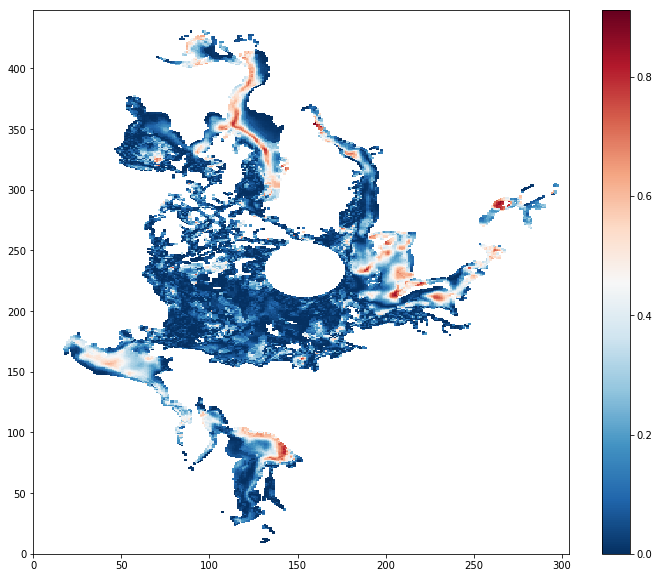

In [60]:
fcast_corr = np.reshape(valid_stats['corr_tot'], (448,304))

fig = plt.figure(figsize=(12,10))
plt.pcolormesh(fcast_corr**2, cmap='RdBu_r')
plt.colorbar()

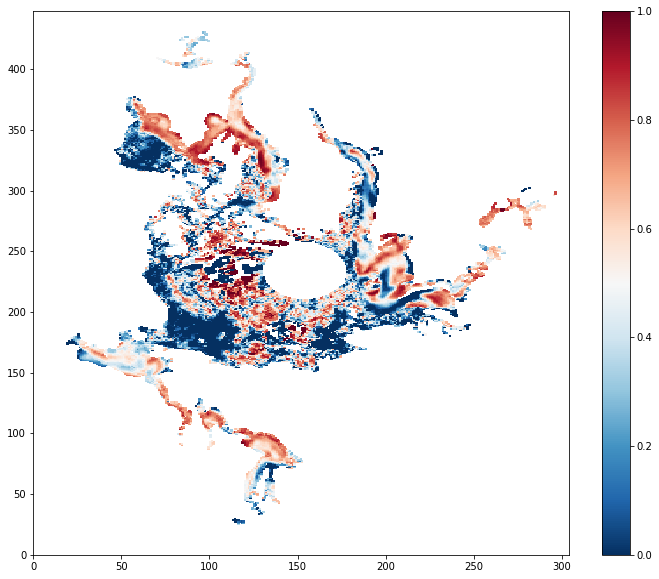

In [61]:
fcast_ce = np.reshape(valid_stats_ar1['corr_tot'], (448,304))

fig = plt.figure(figsize=(12,10))
plt.pcolormesh(fcast_ce, cmap='RdBu_r', vmin=0, vmax=1)
plt.colorbar()

## Validation by lag: 

In [350]:
X_var_valid.shape

(136192, 180)

Lag 0
Truth_anom shape: (136192, 156)
Forecast_anom shape: (136192, 156)


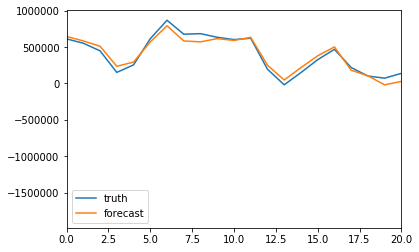

Lag 1
Truth_anom shape: (136192, 155)
Forecast_anom shape: (136192, 155)


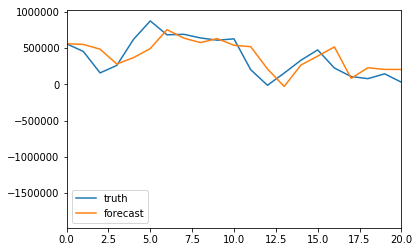

Lag 2
Truth_anom shape: (136192, 154)
Forecast_anom shape: (136192, 154)


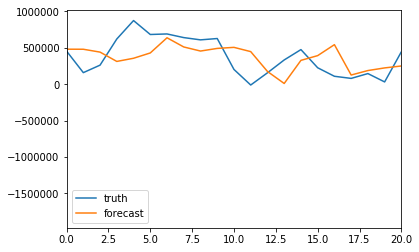

Lag 3
Truth_anom shape: (136192, 153)
Forecast_anom shape: (136192, 153)


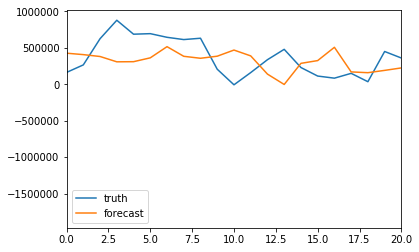

Lag 4
Truth_anom shape: (136192, 152)
Forecast_anom shape: (136192, 152)


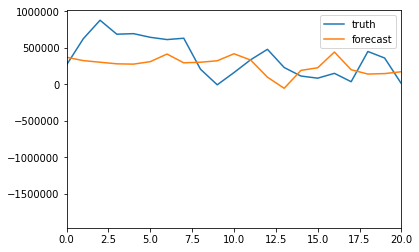

Lag 5
Truth_anom shape: (136192, 151)
Forecast_anom shape: (136192, 151)


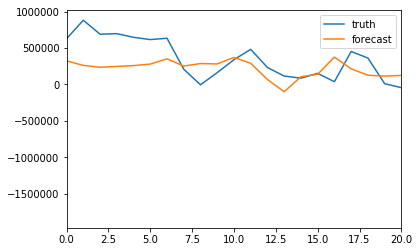

Lag 6
Truth_anom shape: (136192, 150)
Forecast_anom shape: (136192, 150)


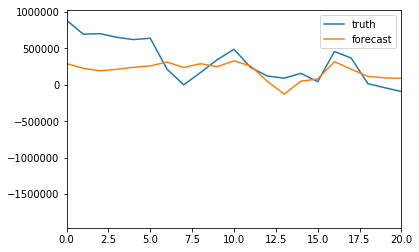

Lag 7
Truth_anom shape: (136192, 149)
Forecast_anom shape: (136192, 149)


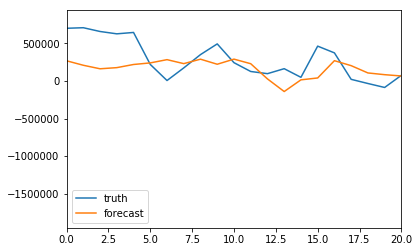

Lag 8
Truth_anom shape: (136192, 148)
Forecast_anom shape: (136192, 148)


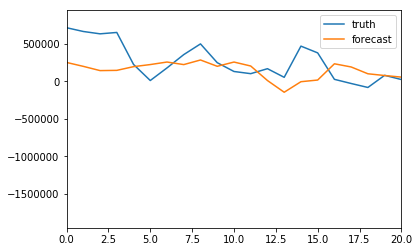

In [311]:
var = 'sic'
iplot=True
# validvars = ['psl']
validation_stats_lag = {}

valid_stats_lag = {}
v_lag = {}

corr_tot = np.zeros((len(lags)))
ce_tot = np.zeros((len(lags)))
gm_var_ratio = np.zeros((len(lags)))

for i,l in enumerate(lags):
    print('Lag '+str(l))
    
    if Insamp==True: 
        x_forecast = x_forecast_dcomp[l,:,l:]
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
        x_truth = X_var_train[:,l:]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
    else:  
        x_forecast = x_forecast_dcomp[l,:,l:]
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]

        x_truth = X_var_valid[:,l:]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

    
    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))
    
    
    tot_var_forecast = statskb.calc_tot_si(forecast_anom, areacell[areawt_name[var]], 
                                           areacell_dict['areacello']['units'], 
                                           var_dict[var]['lat'], lat_cutoff=0.0)
    tot_var_truth = statskb.calc_tot_si(truth_anom, areacell[areawt_name[var]], 
                                        areacell_dict['areacello']['units'], 
                                        var_dict[var]['lat'],lat_cutoff=0.0)
    
    if iplot==True: 
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
       # plt.ylim(-1.5,1.5)
        plt.legend()
        plt.show()
        
    corr_tot[i] = np.corrcoef(tot_var_truth,tot_var_forecast)[0,1]
    ce_tot[i] = LMR_utils.coefficient_efficiency(tot_var_truth,tot_var_forecast)
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom-forecast_anom)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio[i]=gm_error_var/gm_truth_var

valid_stats_lag['corr_tot'] = corr_tot
valid_stats_lag['ce_tot'] = ce_tot
valid_stats_lag['gm_var_ratio'] = gm_var_ratio

validation_stats_lag[var] = valid_stats_lag

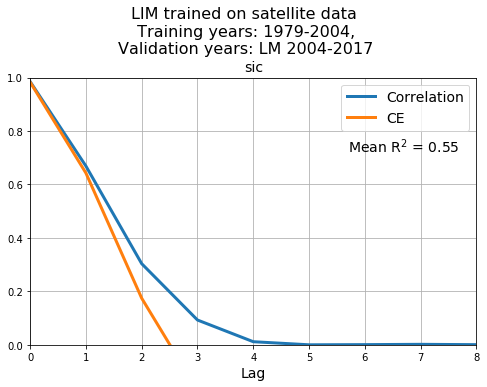

In [312]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(limvars):
    ax.plot(lags, valid_stats_lag['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax.plot(lags, valid_stats_lag['ce_tot'],label='CE',linewidth=3.0)
    
#     ax.plot(corr_plot_ar1**2, label='AR1 Correlation',linewidth=2.0, linestyle='--', color='tab:blue')
#     ax.plot(ce_plot_ar1,label='AR1 CE',linewidth=2.0, linestyle='--', color='tab:orange')

    ax.set_ylim(0,1)
    ax.set_xlim(0,8)
#     ax[i].set_xlim(0,10)
    ax.set_xticks(lags)
#    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=14)
    ax.text(5.7,0.72, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle((' Training years: 1979-2017'+
                 ', Validation years: Same'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \nValidation years: LM '+str(int(1979+ntrain/12))+'-'+str(int(1979+nvalid/12))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax.legend(loc='upper right', fontsize=14)
# ax[2].set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Lag', fontsize=14)

plt.subplots_adjust(top=0.8)

Lag 1
Truth_anom shape: (136192, 155)
Forecast_anom shape: (136192, 155)


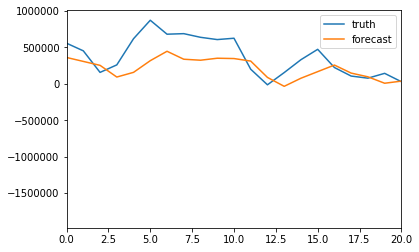

Lag 2
Truth_anom shape: (136192, 154)
Forecast_anom shape: (136192, 154)


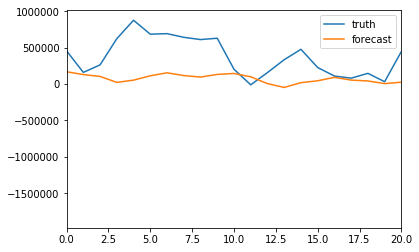

Lag 3
Truth_anom shape: (136192, 153)
Forecast_anom shape: (136192, 153)


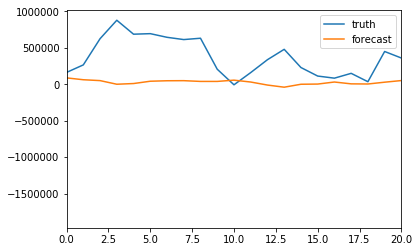

Lag 4
Truth_anom shape: (136192, 152)
Forecast_anom shape: (136192, 152)


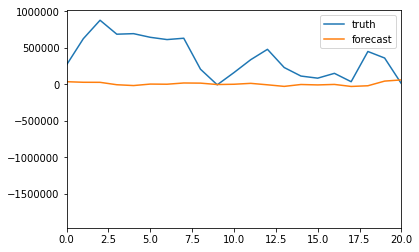

Lag 5
Truth_anom shape: (136192, 151)
Forecast_anom shape: (136192, 151)


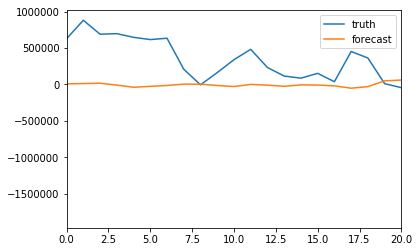

Lag 6
Truth_anom shape: (136192, 150)
Forecast_anom shape: (136192, 150)


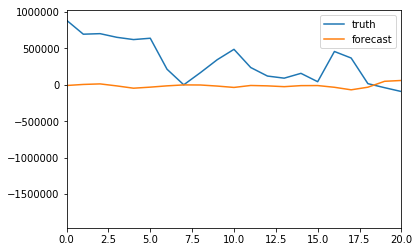

Lag 7
Truth_anom shape: (136192, 149)
Forecast_anom shape: (136192, 149)


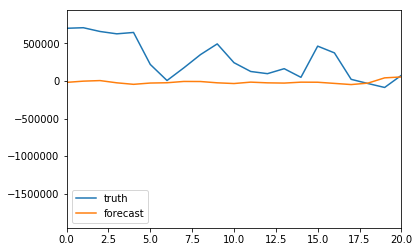

Lag 8
Truth_anom shape: (136192, 148)
Forecast_anom shape: (136192, 148)


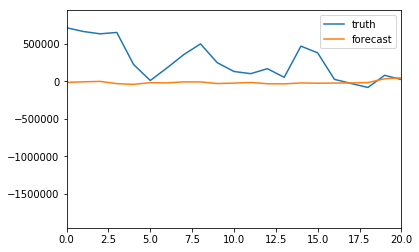

In [313]:
var = 'sic'
iplot=True
# validvars = ['psl']
validation_stats_ar1_lag = {}

valid_stats_ar1_lag = {}
v_ar1_lag = {}

corr_tot = np.zeros((len(lags)))
ce_tot = np.zeros((len(lags)))
gm_var_ratio = np.zeros((len(lags)))
#forecast_ar1_lag = np.zeros((len(lags),X_var_valid.shape[0],X_var_valid.shape[1]))

for i,l in enumerate(lags[1:]):
    print('Lag '+str(l))
    forecast_ar1_lag, ar1_factor = red_noise_forecast_ar1(X_var_train.T, X_var_valid.T, lead=l)
    
    if Insamp==True: 
        x_forecast = forecast_ar1_lag.T
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]
        
        x_truth = X_var_train[:,l:]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
    else:  
        x_forecast = forecast_ar1_lag.T
        forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]

        x_truth = X_var_valid[:,l:]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

    
    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))
    
    
    tot_var_forecast = statskb.calc_tot_si(forecast_anom, areacell[areawt_name[var]], 
                                           areacell_dict['areacello']['units'], 
                                           var_dict[var]['lat'], lat_cutoff=0.0)
    tot_var_truth = statskb.calc_tot_si(truth_anom, areacell[areawt_name[var]], 
                                        areacell_dict['areacello']['units'], 
                                        var_dict[var]['lat'],lat_cutoff=0.0)
    
    if iplot==True: 
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
       # plt.ylim(-1.5,1.5)
        plt.legend()
        plt.show()
        
    corr_tot[i] = np.corrcoef(tot_var_truth,tot_var_forecast)[0,1]
    ce_tot[i] = LMR_utils.coefficient_efficiency(tot_var_truth,tot_var_forecast)
    
    #error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
    error_var = np.nansum((truth_anom-forecast_anom)**2,axis=1)
#    truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
    truth_error_var = np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis])**2,axis=1)

    gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
    gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
    
    gm_var_ratio[i]=gm_error_var/gm_truth_var

valid_stats_ar1_lag['corr_tot'] = corr_tot
valid_stats_ar1_lag['ce_tot'] = ce_tot
valid_stats_ar1_lag['gm_var_ratio'] = gm_var_ratio

validation_stats_ar1_lag[var] = valid_stats_ar1_lag

In [314]:
ntrain

300

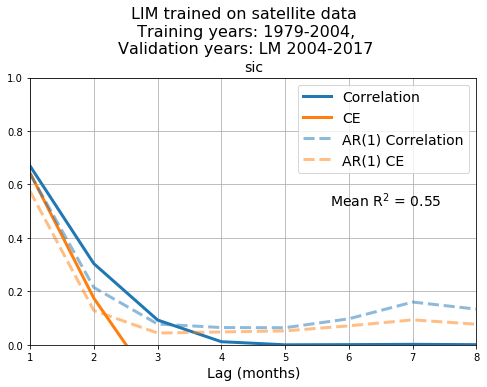

In [316]:
fig,ax = plt.subplots(1,1,figsize=(8,5.5))
#fig,axs= plt.subplots(2, 2)

# ax = axs.flatten()

for i,var in enumerate(limvars):
    ax.plot(lags, valid_stats_lag['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax.plot(lags, valid_stats_lag['ce_tot'],label='CE',linewidth=3.0)
    
    ax.plot(lags[1:], valid_stats_ar1_lag['corr_tot'][:-1]**2, label='AR(1) Correlation',
            linewidth=3.0, linestyle='--', color='tab:blue', alpha=0.5)
    ax.plot(lags[1:], valid_stats_ar1_lag['ce_tot'][:-1], label='AR(1) CE',linewidth=3.0, 
            linestyle='--', color='tab:orange', alpha=0.5)

    ax.set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax.set_xticks(lags)
#    ax.set_xticklabels(month_names,fontsize=12)
    ax.grid(axis='both')
    ax.set_title(var, fontsize=14)
    ax.text(5.7,0.52, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle((' Training years: 1979-2017'+
                 ', Validation years: Same'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on satellite data \n Training years: 1979-'+str(int(1979+ntrain/12))+
                  ', \nValidation years: LM '+str(int(1979+ntrain/12))+'-'+str(int(1979+nvalid/12))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)

plt.xlim(1,8)

ax.legend(loc='upper right', fontsize=14)
# ax[2].set_xlabel('Forecasted month', fontsize=14)
# ax[1].set_xlabel('Forecasted month', fontsize=14)
ax.set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.8)